To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Qwen3 Guide](https://docs.unsloth.ai/basics/qwen3-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


In [15]:
# I wonder if this works?

### Installation

In [16]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [17]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.6.2: Fast Mllama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [18]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model.vision_model.transformer` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled version of the ROCO radiography dataset. You can access the dataset [here](https://huggingface.co/datasets/unsloth/Radiology_mini). The full dataset is [here](https://huggingface.co/datasets/eltorio/ROCOv2-radiology).

The dataset includes X-rays, CT scans and ultrasounds showcasing medical conditions and diseases. Each image has a caption written by experts describing it. The goal is to finetune a VLM to make it a useful analysis tool for medical professionals.


In [73]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("MananSuri27/Flowchart2Mermaid")

Let's take a look at the dataset, and check what the 1st example shows:

In [20]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 1187
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 132
    })
})

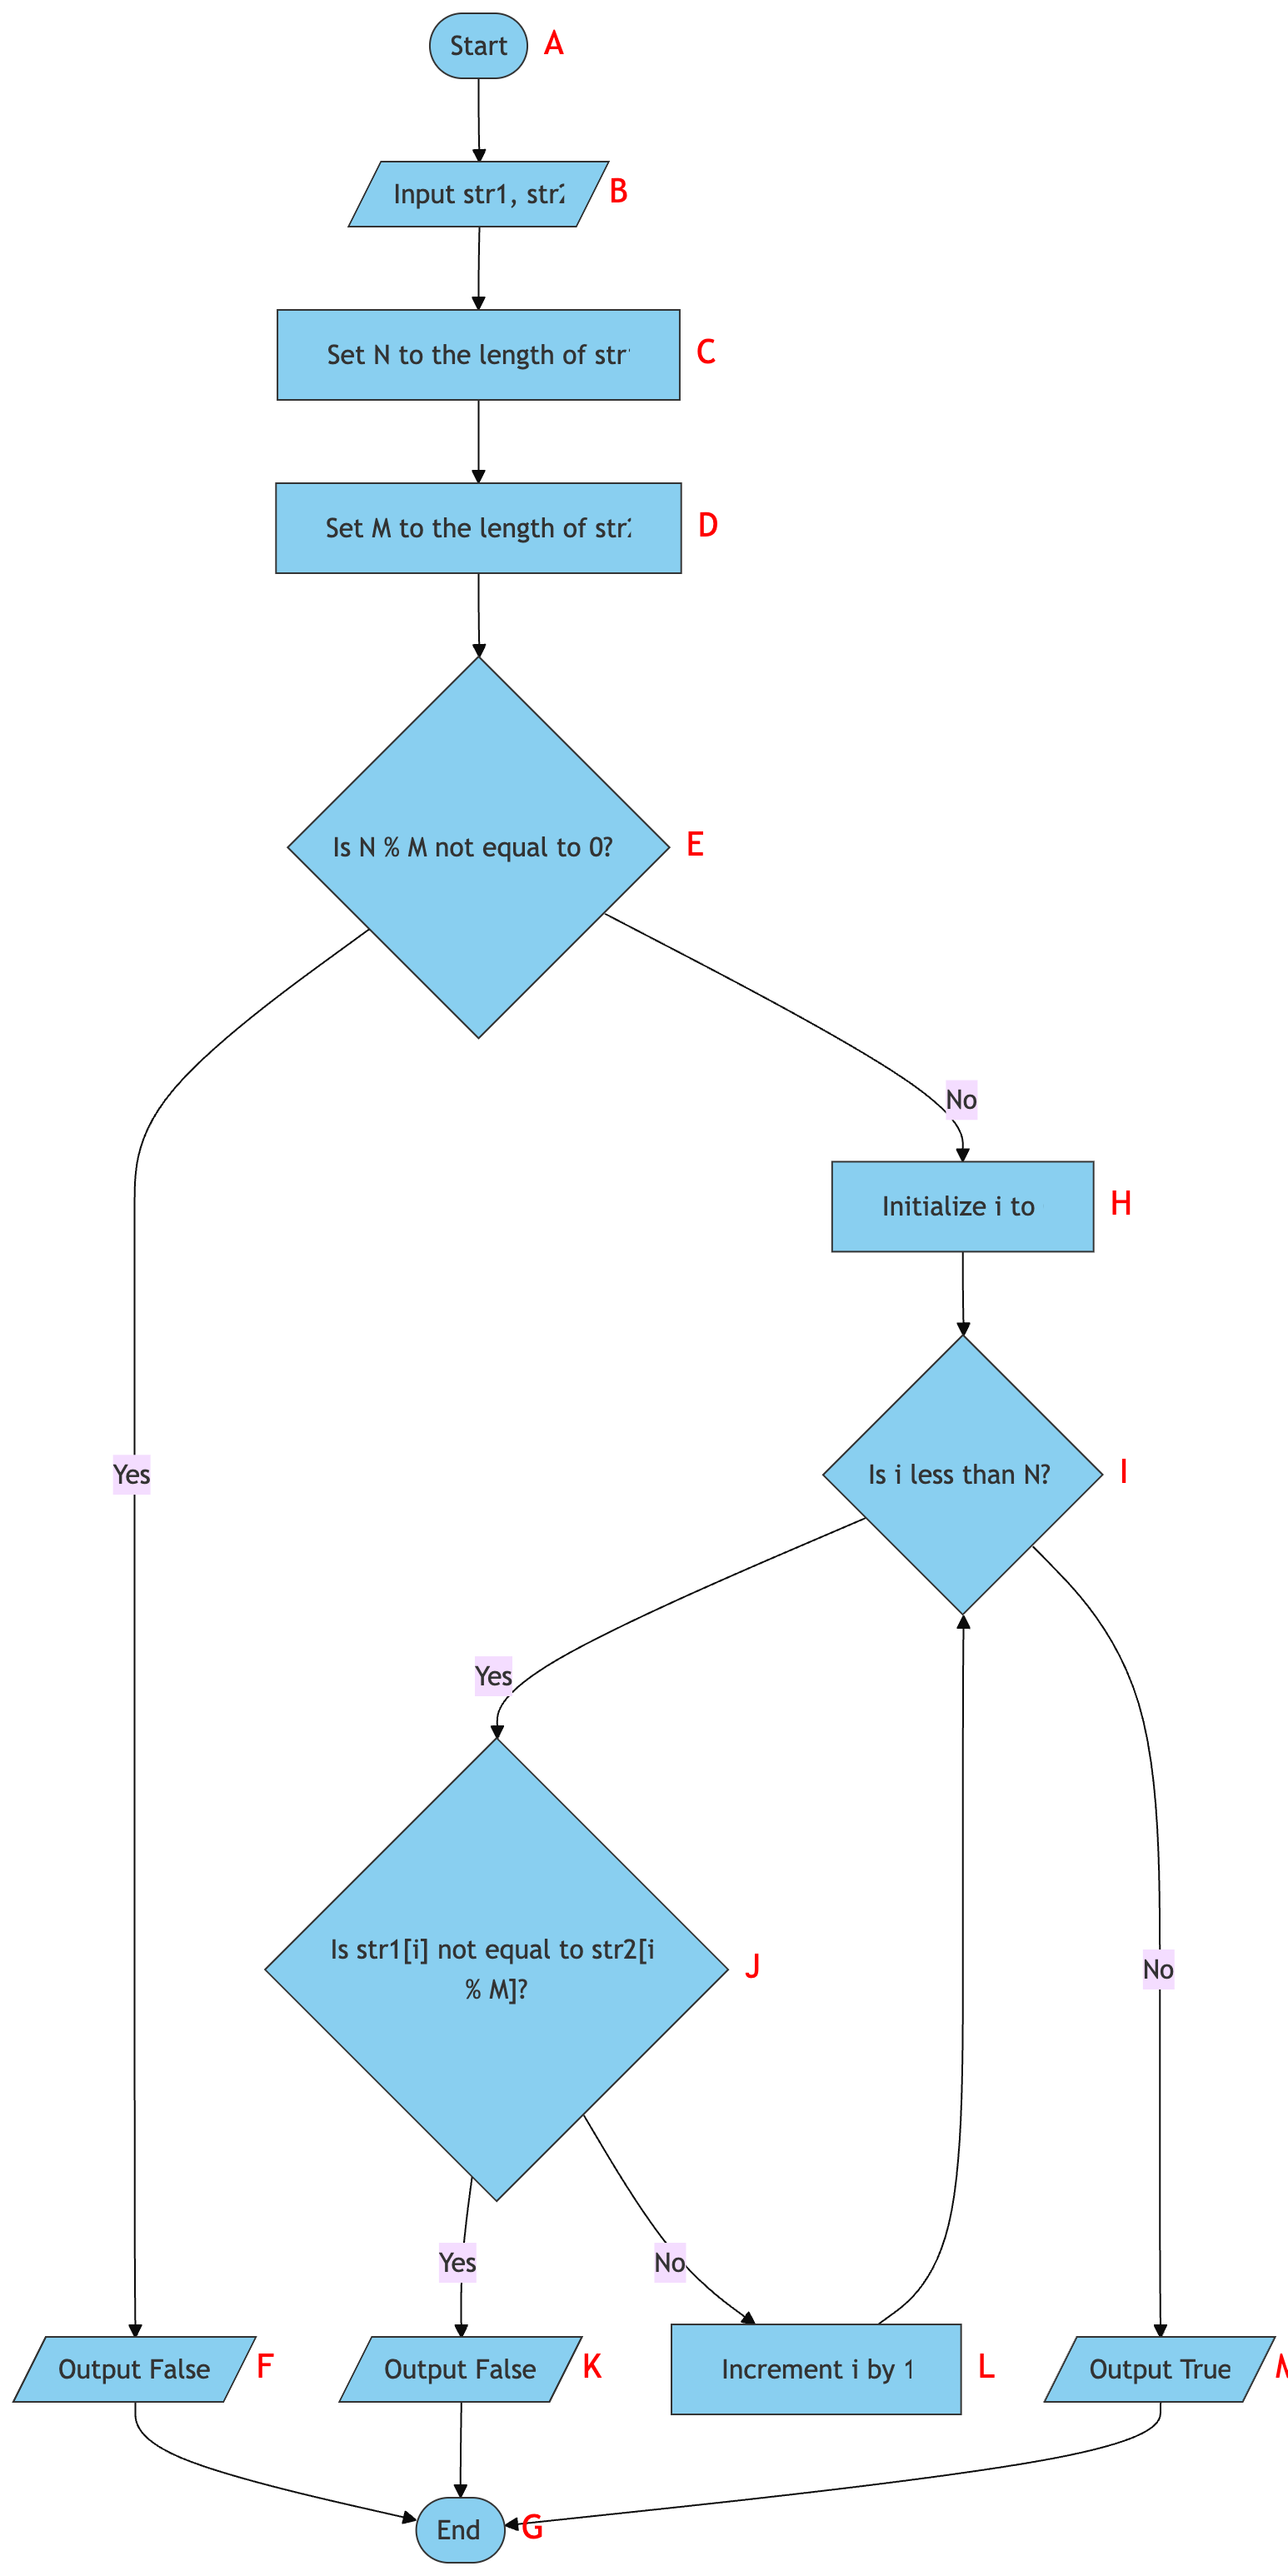

In [48]:
ds["train"][0]['image']

In [47]:
ds["train"][0]['text']

'flowchart TD\n    A(["Start"]) --> B[/"Input str1, str2"/]\n    B --> C["Set N to the length of str1"]\n    C --> D["Set M to the length of str2"]\n    D --> E{"Is N % M not equal to 0?"}\n    E -->|Yes| F[/"Output False"/]\n    F --> G(["End"])\n    E -->|No| H["Initialize i to 0"]\n    H --> I{"Is i less than N?"}\n    I -->|Yes| J{"Is str1[i] not equal to str2[i % M]?"}\n    J -->|Yes| K[/"Output False"/]\n    K --> G\n    J -->|No| L["Increment i by 1"]\n    L --> I\n    I -->|No| M[/"Output True"/]\n    M --> G'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [67]:
instruction = "You are an expert reading and understanding flowcharts "

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ] #ds["train"][0]['image'] ds["train"][0]['text']
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [75]:
new=[]
for i in range(1000):
    diccion={}
    image=ds["train"][i]['image']
    text=ds["train"][i]['text']
    diccion["image"]=image
    diccion["caption"]=text
    new.append(diccion)
ds =new

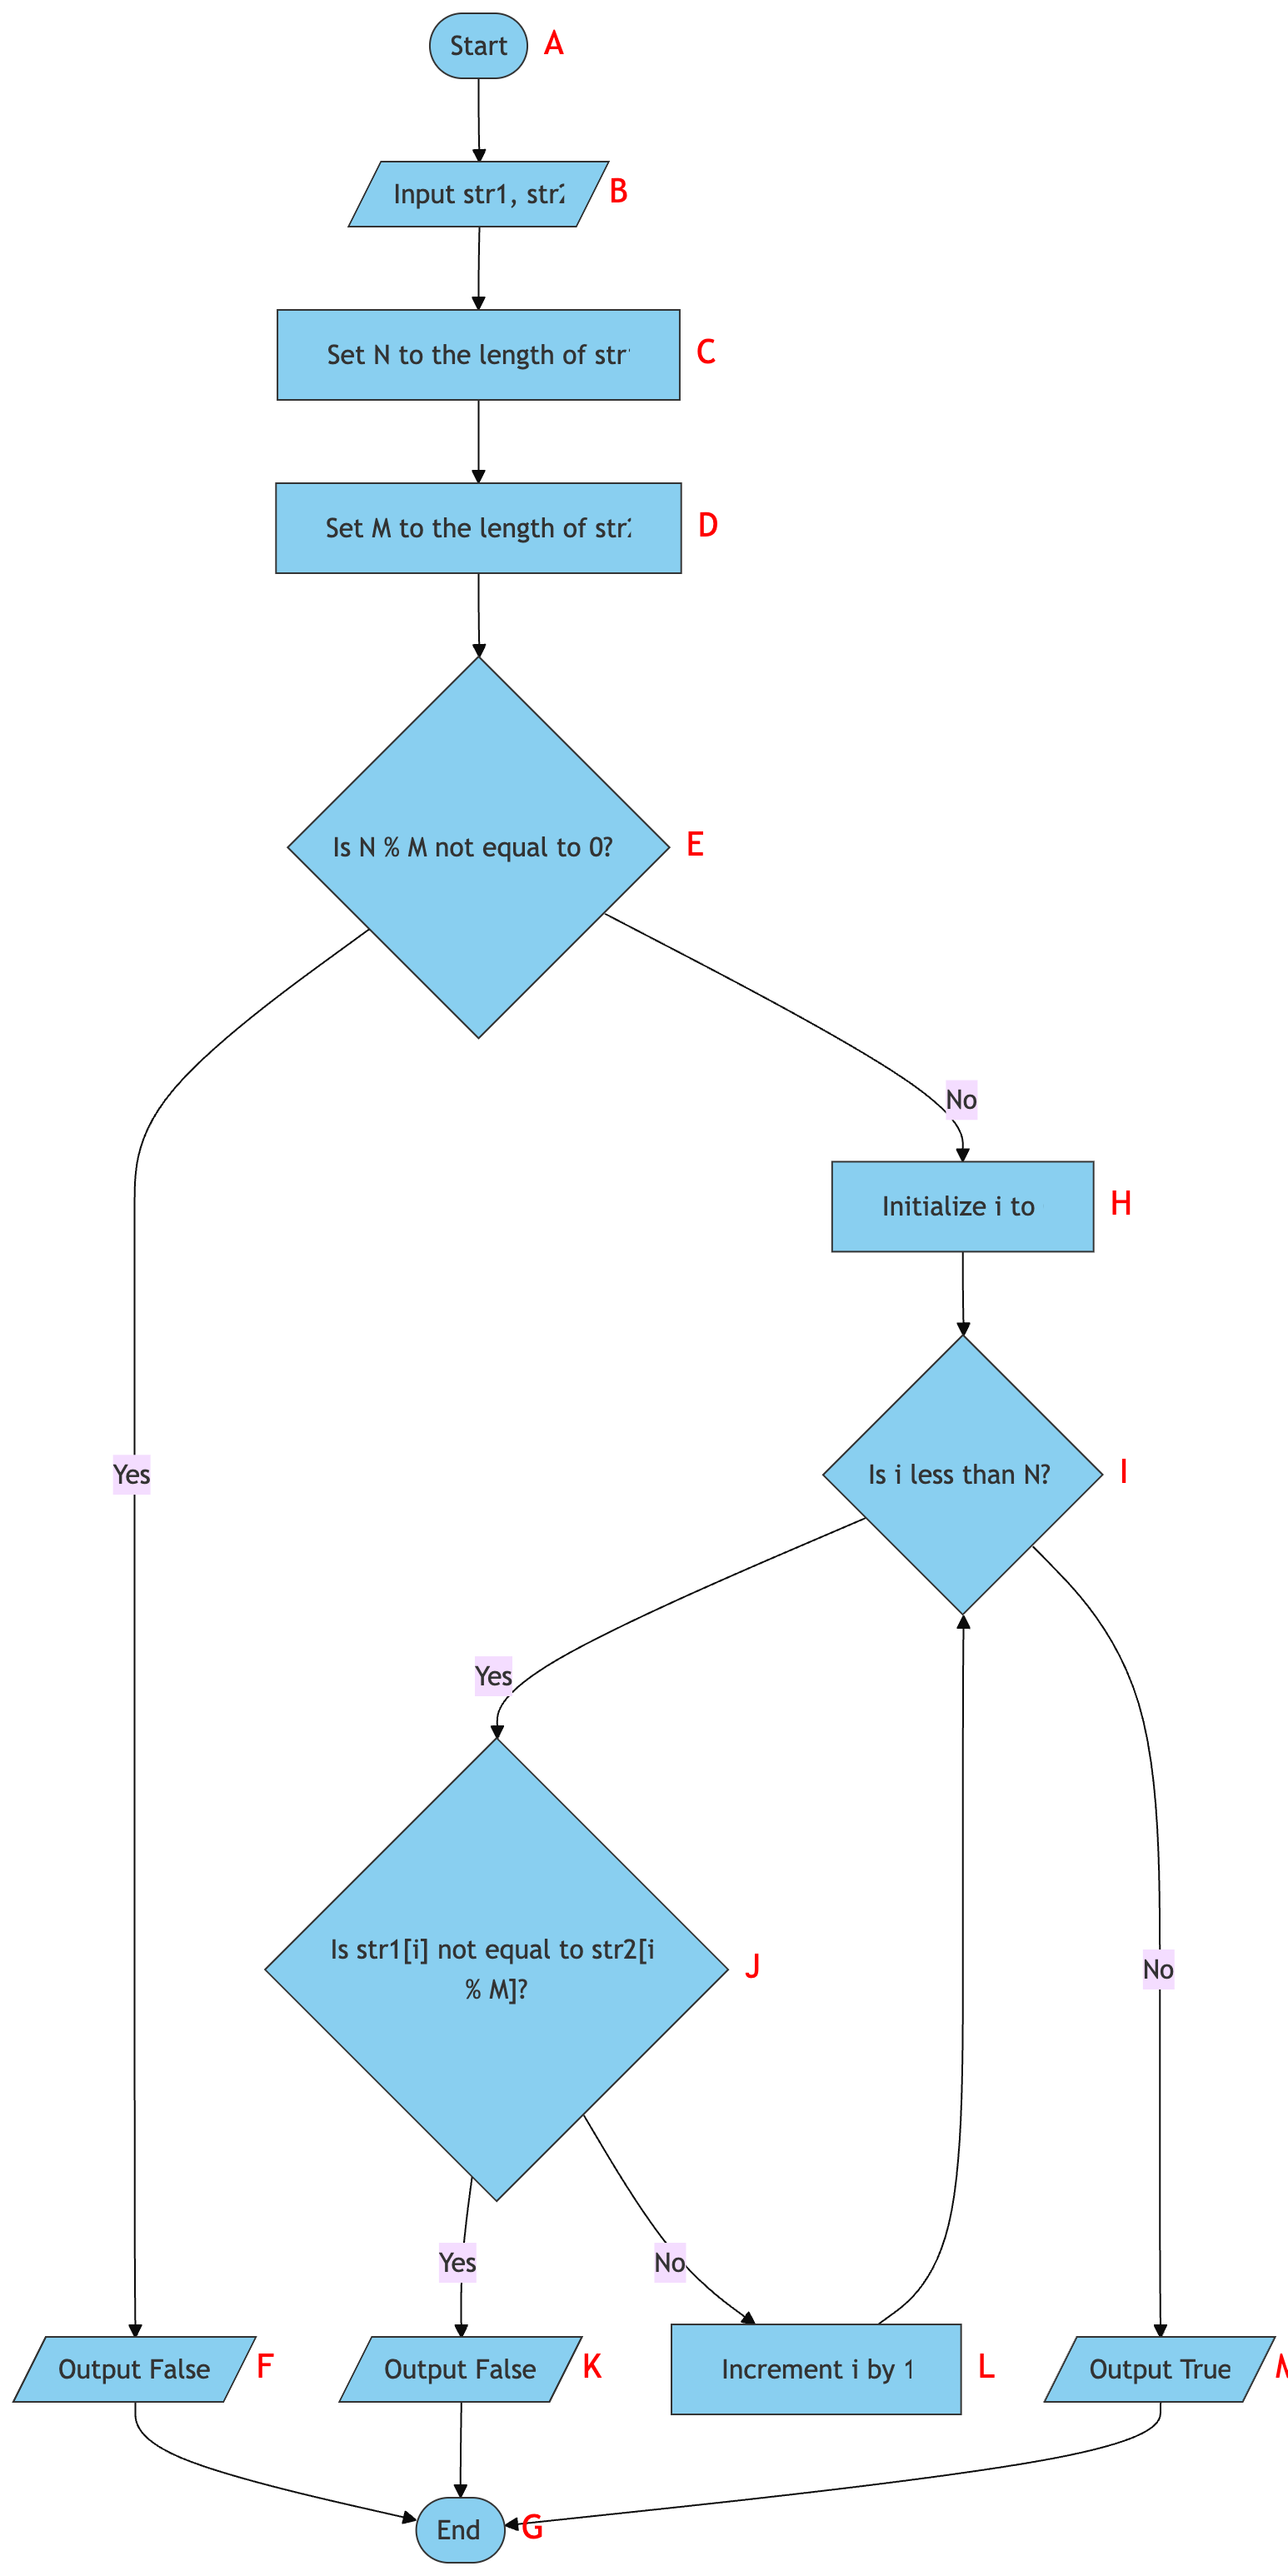

In [80]:
ds[0]['image']

In [76]:
converted_dataset = [convert_to_conversation(sample) for sample in ds]

The first example is now structured like below:

In [79]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert reading and understanding flowcharts'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1546x3092>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'flowchart TD\n    A(["Start"]) --> B[/"Input str1, str2"/]\n    B --> C["Set N to the length of str1"]\n    C --> D["Set M to the length of str2"]\n    D --> E{"Is N % M not equal to 0?"}\n    E -->|Yes| F[/"Output False"/]\n    F --> G(["End"])\n    E -->|No| H["Initialize i to 0"]\n    H --> I{"Is i less than N?"}\n    I -->|Yes| J{"Is str1[i] not equal to str2[i % M]?"}\n    J -->|Yes| K[/"Output False"/]\n    K --> G\n    J -->|No| L["Increment i by 1"]\n    L --> I\n    I -->|No| M[/"Output True"/]\n    M --> G'}]}]}

Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [81]:
FastVisionModel.for_inference(model) # Enable for inference!

image = ds[0]["image"]
instruction = "You are an expert reading and understanding flowcharts"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

I am happy to help you with your flowchart question!

To determine the value of str1, we need to follow the flowchart and break it down step by step.

**Step 1: Input str1 and str**

The input operation simply stores the values of str1 and str in variables. This means that the value of str1 is the input string.

**Step 2: Set N to the length of str**

The length of str is the number of characters in the string. This means that N is equal to the number of characters in str1.

**Step 3: Set M to the length of str**

The same as Step 2, M is also equal to the number of characters in str1.

**Step 4: Is N % M not equal to 0?**

In this case, N % M means the remainder when N is divided by M. If N % M is not equal to 0, it means that N is not a multiple of M. Since N is equal to M, it means that N is not a multiple of M itself.

**Step 5: Is I less than N?**

Since I is not specified, we will assume that I starts from a value greater than or equal to N.

**Step 6: Is str[I] not equal to str2

In [87]:
from PIL import Image
img = Image.open("/content/exam.jpg").convert("RGB")

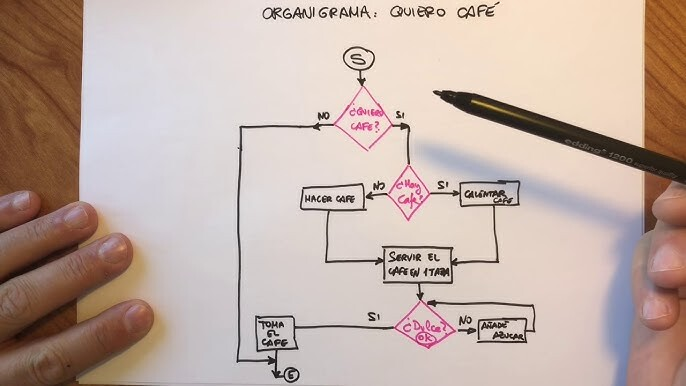

In [89]:
img

In [91]:
instruction = "You are an expert reading and understanding flowcharts, please describe what you see"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    img,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This is a complex flowchart created in a foreign language, primarily Spanish. A user starts at "ORGANIGRAMA: QUIERO CAPE" at the top, with two different pathways for each starting option, marked by a diamond shape and colored pink.

**Pathway 1: Customer Care**

* "Café de Men C" is marked at the bottom.
* An arrow from there directs the user to "Toma el Cafe," indicating a coffee to-go option.

**Pathway 2: Cafe**

* An arrow leads from "Calentar" to the top and the other direction to "Servir el Café en Itaba." Both of these arrows lead to a box labeled "No".

**Pathway 3: Café**

* This path has one option that directs the user to the same starting point, marked "S."

**Additional Notes**

* The flowchart appears to be created on paper using a marker pen and features a hand in the image, holding the chart. A shadow cast from the pen on the flow chart suggests an external light source.

The flowchart seems to outline an algorithm for an imaginary restaurant where an employee could go 

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [93]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [94]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,174,400/11,000,000,000 (0.61% trained)


Step,Training Loss
1,0.746300
2,0.802300
3,0.884600
4,0.695300
5,0.556100
6,0.445300
7,0.325000
8,0.325800
9,0.286000
10,0.212000


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [102]:
FastVisionModel.for_inference(model) # Enable for inference!

image = img
instruction = "You are an expert reading and understanding flowcharts, describe each part of the flowchart in the image"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500,
                   use_cache = True, temperature = 2.0, min_p = 0.1)

flowchart TD
    I(["Ínicio"]) --> O1{"¿Toma El Cofé?"}
    O1 -->|Sí / No | SI[("Servir el Cofé en Tiempo")]
    O1 -->|No | GI[("Galería Café")]

    SI --> O2{"¿Se Quiere Comprar el Café en Tiempo?"}
    SI -->|No | O3["Dolors (Por Falta de Cafe o Servicio en Tiempo)"]
    O3 --> I

    SI -->|Sí | SI["Servir El Café en Tiempo"]
    SI --> O2

    O2 --> O3{"¿Por Dolor o Servicio en Tiempo??"}
    O3 -->|Dolores o Servicio en Tiempo| D1[("Devuelve el Dinero al Cliente por el Falto")]

    O2 -->|Sí| SI
    SI --> O4[("Si Se Quiere, Servirlo, Pues Ya Tiempo Es Valido")]
    SI --> GI["(Servir lo Demas al Café por Si Al Cliente Deseaba más)");

    GI --> D1


This flowchart illustrates how coffee would be handled during peak hours while being served to customers, if they wanted it, the server must make the time limit to avoid delay, serving them by then, if it is past 3pm the customer gets a notification asking if they want to continue. If so, then it will serve him, but if the custo

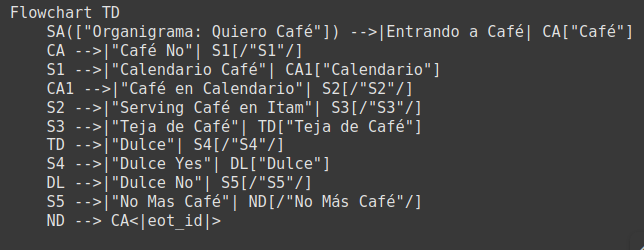

The image displays a flowchart that begins at the top of the page, where "ORGANIGRAMA: QUIEPO CAFE" is written in black marker ink. A circle labeled with an "s" is followed by an arrow that splits into two paths. On the right-hand path, there is a diamond containing the Spanish phrase "CAFE 2." Another arrow then splits this path into two lines leading to two parallel boxes that read, "NO" and "SI." "SI" leads to a line that flows towards another diamond with "Cafetera" written inside, while "NO" leads to the line that splits again towards boxes reading "HORAS CAPE" and "SERVIR EL CAFÉ EN 15MIN." A box reading "S1" is present at the bottom of this split arrow.

On the left-hand path, "NO" leads to a line that splits again towards boxes reading "TONAS DE CAFE" and "S1," while "SI" leads to a line that flows towards another diamond with "Dulce" written inside. These arrows then connect to the bottom line of the flowchart, where they lead to boxes reading "NO" and "ASADRE ARENA." The lines that follow these boxes split to the right-hand side and read "NO" and "SI," before terminating the flowchart.

The background appears to be a brown wooden surface, with the hand of the person holding the pen visible on the right, while their left hand holds the flowchart paper, which sits on the left. The pen and paper seem to be resting on a wooden surface, with a subtle shadow cast onto the surface in front of the hand and pen.<|eot_id|>

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [97]:
model.save_pretrained("lora_modelimagesjaj")  # Local saving
tokenizer.save_pretrained("lora_modelimagesjajaj")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert reading and understanding flowcharts, describe accurately what do you watch"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
